In [2]:
import lightgbm as lgb
import numpy as np
import pandas as pd
import shap
from sklearn.model_selection import StratifiedKFold

In [3]:
input_train = pd.read_csv('../data/new_base/train.csv')
input_test = pd.read_csv('../data/new_base/test.csv')

print(input_train.describe())
print('-----------------------')
print(input_test.describe())


         Survived      Pclass         Sex         Age       SibSp       Parch  \
count  891.000000  891.000000  891.000000  891.000000  891.000000  891.000000   
mean     0.383838    2.308642    0.647587   29.361582    0.523008    0.381594   
std      0.486592    0.836071    0.477990   13.019697    1.102743    0.806057   
min      0.000000    1.000000    0.000000    0.420000    0.000000    0.000000   
25%      0.000000    2.000000    0.000000   22.000000    0.000000    0.000000   
50%      0.000000    3.000000    1.000000   28.000000    0.000000    0.000000   
75%      1.000000    3.000000    1.000000   35.000000    1.000000    0.000000   
max      1.000000    3.000000    1.000000   80.000000    8.000000    6.000000   

             Fare        Miss  Embarked_C  Embarked_Q  Embarked_S  
count  891.000000  891.000000  891.000000  891.000000  891.000000  
mean    32.204208    0.198653    0.188552    0.086420    0.725028  
std     49.693429    0.399210    0.391372    0.281141    0.446751 

In [4]:
train_desc = input_train.drop(columns=['Survived'], errors='ignore').describe()
test_desc = input_test.drop(columns=['PassengerId'], errors='ignore').describe()

# 差分の絶対値をとって違いを確認
diff = (train_desc / test_desc).abs()

# 差の大きいところだけ表示（例：差が大きい順に並べる）
print(diff.sort_values(by='mean', axis=1, ascending=False))

          SibSp  Embarked_S    Pclass       Sex       Age     Parch      Miss  \
count  2.131579    2.131579  2.131579  2.131579  2.131579  2.131579  2.131579   
mean   1.169076    1.122451  1.019020  1.017637  0.991969  0.972599  0.965547   
std    1.229698    0.933059  0.993150  0.992459  1.024869  0.821310  0.986370   
min         NaN         NaN  1.000000       NaN  2.470588       NaN       NaN   
25%         NaN         NaN  2.000000       NaN  0.956522       NaN       NaN   
50%         NaN    1.000000  1.000000  1.000000  1.037037       NaN       NaN   
75%    1.000000    1.000000  1.000000  1.000000  0.979021       NaN       NaN   
max    1.000000    1.000000  1.000000  1.000000  1.052632  0.666667  1.000000   

           Fare  Embarked_Q  Embarked_C  
count  2.131579    2.131579    2.131579  
mean   0.905209    0.785293    0.772694  
std    0.889764    0.897283    0.910128  
min         NaN         NaN         NaN  
25%    1.001849         NaN         NaN  
50%    1.000000   

In [13]:
def k_gbm_shap(input_train, input_test, params, n_splits=5):
    X = input_train.drop(['Survived'], axis=1, inplace=False)
    y = input_train['Survived']
    x_test = input_test.drop(['PassengerId'], axis=1, inplace=False)

    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    models = []
    scores = []
    shap_values_list = []
    explainer_list = []

    test_preds = np.zeros(len(input_test))

    for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
        
        print(f"Fold {fold+1}/{n_splits}")
        
        x_train, x_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx] 
        
        train_data = lgb.Dataset(x_train, label=y_train)
        val_data = lgb.Dataset(x_val, label=y_val)
        
        
        model = lgb.train(
            params,
            train_data,
            valid_sets=[val_data],
            callbacks=[lgb.early_stopping(stopping_rounds=10),
                       lgb.log_evaluation(10)
                       ]
            
            )
        
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(x_test)
        
        shap_values_list.append(shap_values)
        explainer_list.append(explainer)
        
    print(np.array(shap_values_list).shape)  # (n_splits, サンプル数, 特徴量数)

    shap_values_mean = np.mean(shap_values_list, axis=0)
    
    print(np.array(shap_values_list).shape)
    print(shap_values_mean.shape)  # 期待値: (サンプル数, 特徴量数)


    shap.summary_plot(shap_values_mean, x_test)
    return shap_values_mean, shap_values_list



Fold 1/5
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002161 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 202
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 10
[LightGBM] [Info] Start training from score 0.383427
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

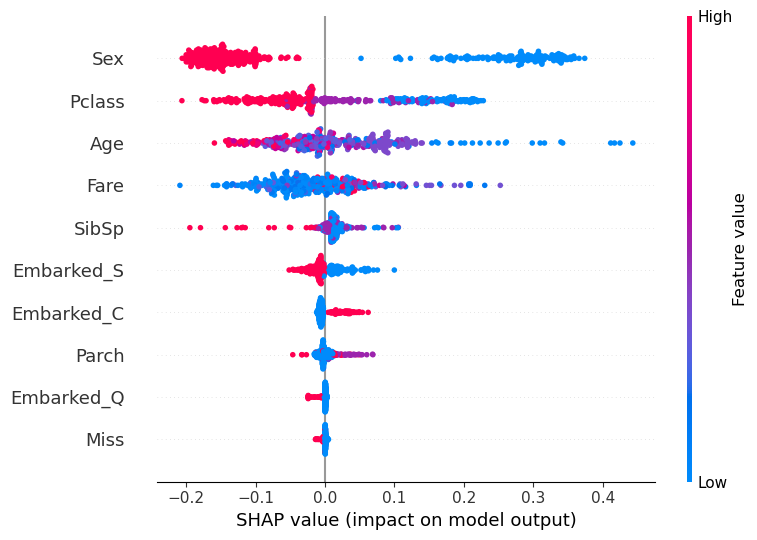

In [15]:
input_train = pd.read_csv('../data/new_base/train.csv')
input_test = pd.read_csv('../data/new_base/test.csv')
best_params = {
     'learning_rate': 0.1109006773045451,
     'num_leaves': 64,
     'max_depth': 11,
     'min_child_samples': 9,
     'subsample': 0.5623226907045367,
     'colsample_bytree': 0.5737897762821246, 
     'lambda_l1': 0.15874498150345134, 
     'lambda_l2': 0.0008756575871445052
     }
shap_values_mean, shap_values_list = k_gbm_shap(input_train, input_test, params=best_params, n_splits=5)


NameError: name 'shap_values_list' is not defined